<a href="https://colab.research.google.com/github/GerardoxCarreon/FisicaComputacional1/blob/master/Actividad6/Actividad6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Actividad 6***
"Pronóstico de Series de Tiempo" 

---

Para esta la actividad 6 de física computacional, se explorará un tema de suma importancia y utilidad aunque también de moderada complejidad, este es el pronóstico de series de tiempo. Así como se menciona, lo que se busca en esta práctica es continuar con la muestra de datos de la estación meteorológica con la que hemos estado trabajando y tomar un paso más grande en el análisis de datos al predecir cómo será la información que reciba esta estación en las próximas semanas o hasta meses. Para esto se emplea el uso de nuevas herramientas de análisis estadístico y bibliotecas de Python con las que se buscará crear una serie de tiempo estacionaria, esto quiere decir que sus propiedades estadísticas como promedio, varianza, covarianza y muchas otras permanezcan constantes a lo largo del tiempo, en la cual nos podamos basar para lograr una predicción de información aceptable.  
 
Estas nuevas herramientas que se usarán durante esta actividad son las siguientes:
 
* ***Statsmodel:*** Biblioteca madre que sirve para análisis de series de tiempo y modelos pronósticos
*  ***AdFuller:*** Herramienta procedente de la biblioteca de stastmodel y que es ni nada más ni nada menos que la Prueba Aumentada de Dickey-Fuller (ADF) que sirve para rechazar o no la hipótesis de que una serie es estacionaria o no
*  ***ARIMA:*** Al igual que AdFuller, es una herramienta procedente de la biblioteca de stastmodel y que sirve para rechazar o no la hipótesis de serie estacionaria

In [ ]:
#Aqui introducimos las bibliotecas a utilizar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#Para calcular las estacionalidad, tendencia y residuo 
import statsmodels.api as sm
#Bibliotecas para el análisis de Series de Tiempo y Modelos de Pronóstico
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from statsmodels.tsa.stattools import acf, pacf

import pandas.util.testing as tm

#Suprimir mensajes de alertas de cambios futuros
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# Matplotlib mostrará los resultados en la Notebook de Jupyter
%matplotlib inline

In [ ]:
#------------------------------------------------RETOMAMOS NUESTRO DATAFRAME DE LA ACTIVIDAD PASADA-------------------------------------------------------------------------------------

#Definimos como la direccion url donde se ubica nuestro archivo
url="https://raw.githubusercontent.com/GerardoxCarreon/FisicaComputacional1/master/Actividad3/Copia%20de%20Climatologia%20diaria_La%20Paz.txt"

#Definimos manualmente los nombres para nuestras columnas mediante la función my_cols
my_cols=[ 'Fecha' , 'Precip' , 'Evap' , 'Tempmax' , 'Tempmin' ]
#Definimos nuestro archivo como un csv con parametros para poder leerlo como Dataframe 
df_clim = pd.read_csv(url, names=my_cols, encoding='cp1252', sep='\s+', header=None, skiprows=19, skipfooter=1, skip_blank_lines=True, engine='python')

#Realizamos una copia del primer DataFrame 
df_cop=df_clim.copy()

#Sustituimos los valores marcados como Nulo en el DataFrame por espacios en blanco
#Para esto deberemos sustituir la copia del primer DataFrame por otra copia
str_Nulo = 'Nulo'
df_cop2 = df_cop.replace(to_replace=str_Nulo, value='', regex=True)

#Ahora convertiremos todos los valores numericos que el DataFrame almaceno como objetos a numeros flotantes
#Los datos que se convertiran en numeros flotantes seran los que se encuentran en las columnas de Precipitacion, Evaporacion, Tempmax y Tempmin
cols_list=['Precip', 'Evap', 'Tempmax', 'Tempmin']
for cols in cols_list:
  df_cop2[cols]=pd.to_numeric(df_cop2[cols], errors='coerce')

#Nuevamente realizamos una copia del ultimo DataFrame
df_cop3=df_cop2.copy()

#Ahora convertiremos la informacion almacenada en la columna de Fecha del DataFrame de objeto a formato datetime
#Utilizamos la función pd.to_datetime que convierte la fecha en datetime 
#Definimos que la fecha este ordenada por dia, mes, año
df_cop3['Fecha']=pd.to_datetime(df_cop3['Fecha'], dayfirst=True).copy()

#Creamos dos nuevas columnas para el DataFrame las cuales contendran el Mes y Año de los datos, para esto extraeremos estos valores de la recien creada columna de Fecha
#Usaremos la función .dt.year y .dt.month para extraer el Año y Mes de la Fecha
df_cop3['Año'] = df_cop3['Fecha'].dt.year
df_cop3['Mes'] = df_cop3['Fecha'].dt.strftime('%b')

#Nuevamente realizamos una copia del ultimo DataFrame
df_cop4=df_cop3.copy()

#En este paso, convertiremos la columna de Mes de variable numerica a variable categorica con la función .dt.strftime('%b'), esto con la finalidad de poder utilizar estas variables como etiquetas en una posible gráfica de datos
df_cop4.drop('Mes', axis=1, inplace=True)
df_cop4['Mes'] = df_cop3['Fecha'].dt.strftime('%b')

#Nuevamente realizamos una copia del ultimo DataFrame
df_cop5_ts=df_cop4.copy()
#Hacemos que la variable 'Fecha' sea el nuevo indice de nuestro DataFrame
df_cop5_ts=df_cop5_ts.set_index('Fecha')
#Comprobamos que se haya cambiado el indice
print('INFORMACION DE DATAFRAME\n')
df_cop5_ts.info()
print('')
print('ENCABEZADO DE DATAFRAME\n')
print(df_cop5_ts.head())
print('')
print('PIE DE DATAFRAME\n')
print(df_cop5_ts.tail())
#------------------------------------------------------FIN DE NUESTRO DATAFRAME DE LA ACTIVIDAD PASADA-------------------------------------------------------------------------------------

INFORMACION DE DATAFRAME

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 18661 entries, 1961-04-18 to 2017-12-31
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Precip   18659 non-null  float64
 1   Evap     1238 non-null   float64
 2   Tempmax  18658 non-null  float64
 3   Tempmin  18657 non-null  float64
 4   Año      18661 non-null  int64  
 5   Mes      18661 non-null  object 
dtypes: float64(4), int64(1), object(1)
memory usage: 1020.5+ KB

ENCABEZADO DE DATAFRAME

            Precip  Evap  Tempmax  Tempmin   Año  Mes
Fecha                                                
1961-04-18     0.0   NaN     33.0      NaN  1961  Apr
1961-04-19     0.0   NaN     31.0     12.5  1961  Apr
1961-04-20     0.0   NaN     31.0     12.0  1961  Apr
1961-04-21     0.0   NaN     33.0     16.0  1961  Apr
1961-04-22     0.0   NaN     36.0     16.0  1961  Apr

PIE DE DATAFRAME

            Precip  Evap  Tempmax  Tempmin   Año  Mes
Fec

*   # ***Actividad 1.*** 
Tomar una serie de datos en un periodo sin huecos (Tmax, Tmin) de la estación que se está analizando, para probar si es una serie de tiempo estacionaria o hacer las transformaciones para convertirla en una. 


In [ ]:
#De nuestro DataFrame original, creamos varios conjuntos de años que tengan el mismo ancho en su intervalo
df_61 = df_cop5_ts[(df_cop5_ts['Año'] >= 1961) & (df_cop5_ts['Año'] < 1977)]
df_77 = df_cop5_ts[(df_cop5_ts['Año'] >= 1977) & (df_cop5_ts['Año'] < 1997)]
df_97 = df_cop5_ts[(df_cop5_ts['Año'] >= 1997) & (df_cop5_ts['Año'] < 2017)]
#Estas 3 colecciones serán nuestras Series de Tiempo (DatFrames) para el análisis

In [ ]:
#Definimos la función que probara si nuestra serie de tiempo es estacionaria: 'timeseries'
def test_stationarity(df_ts):
    #Determinar la Estadística de promedios móviles
    rolmean=df_ts.rolling(window=365, center=True).mean()
    rolstd=df_ts.rolling(window=365, center=True).std() 
    # Define el tamaño de la figura
    plt.rcParams["figure.figsize"] = (12,6)
    #Graficar la Estadística de promedios móviles 
    plt.plot(df_ts, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std Deviation')
    #Etiquetas de ejes y titulo 
    plt.legend(loc='best')
    plt.title('Promedio Móvil y Desviación Estándar')
    plt.grid()
    plt.show()
    #Realiza la Prueba Aumentada de Dickey-Fuller:
    print('Resultados de la Prueba de Dickey-Fuller:')
    dftest = adfuller(df_ts, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], 
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [ ]:
#Creamos la primer serie de Tiempo para analizar a partir de uno de los conjuntos de datos que definimos anteriormente, en este caso sera de los años 1997 a 2017 
#Fechas de inicio y fin, para filtrar la información
start, end = '1997-01', '2017-12'
#Se realiza la serie de tiempo
ts_97= df_97.loc[start:end].copy()
#Imprimimos el encabezado de la serie de tiempo
print('ENCABEZADO DE SERIE DE TIEMPO\n')
ts_97.head()

ENCABEZADO DE SERIE DE TIEMPO



,Precip,Evap,Tempmax,Tempmin,Año,Mes
Fecha,,,,,,
1997-01-01,0.0,NaN,24.0,9.0,1997,Jan
1997-01-02,0.0,NaN,27.0,9.0,1997,Jan
1997-01-03,0.0,NaN,28.0,8.0,1997,Jan
1997-01-04,0.0,NaN,29.0,13.0,1997,Jan
1997-01-05,0.0,NaN,27.0,9.0,1997,Jan


In [ ]:
#Creamos las series de tiempo para las Temperaturas Máximas y Minimas del conjunto de datos de los  años 1997 a 2017
ts_max=ts_97['Tempmax'].copy()
ts_min=ts_97['Tempmin'].copy()

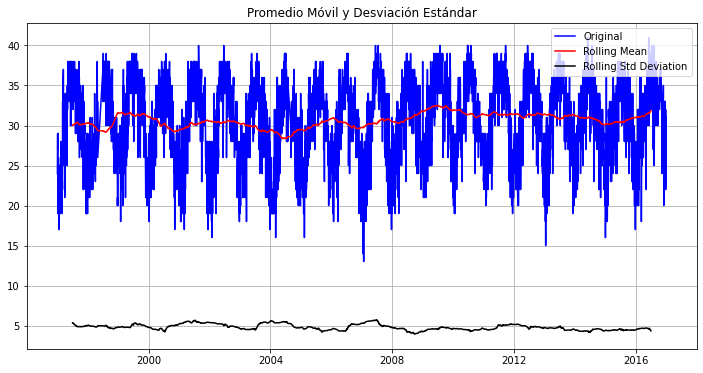

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -5.917851e+00
p-value                        2.547642e-07
#Lags Used                     2.600000e+01
Number of Observations Used    7.182000e+03
Critical Value (1%)           -3.431261e+00
Critical Value (5%)           -2.861943e+00
Critical Value (10%)          -2.566984e+00
dtype: float64


In [ ]:
#Realizamos la prueba de estacionalidad con el metodo de Dickey-Fuller para la serie de Temperatura Máxima y analizamos la información obtenida
test_stationarity(ts_max)

In [ ]:
#Podemos apreciar que el valor p de ADF: p < 0.05 (0.001435) por lo tanto, la tendencia y la estacionalidad hacen que sea una serie estacionaria

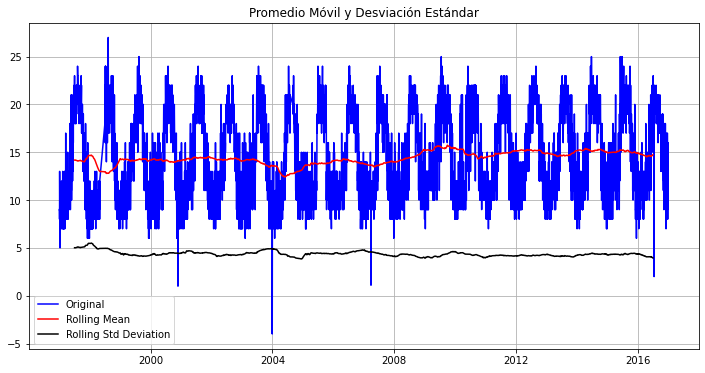

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -5.879740e+00
p-value                        3.098560e-07
#Lags Used                     1.300000e+01
Number of Observations Used    7.195000e+03
Critical Value (1%)           -3.431259e+00
Critical Value (5%)           -2.861942e+00
Critical Value (10%)          -2.566984e+00
dtype: float64


In [ ]:
#Realizamos la prueba de estacionalidad con el metodo de Dickey-Fuller para la serie de Temperatura Minima y analizamos la información obtenida
test_stationarity(ts_min)

In [ ]:
#Podemos apreciar que el valor p de ADF: p < 0.05 (0.000364) por lo tanto, la tendencia y la estacionalidad hacen que sea una serie estacionaria

*   # ***Actividad 2.***  
Construye los modelos ARIMA para cada Temperatura (Tmax y Tmin), y contrasta la bondad del ajuste en cada caso, calculando el error de la raíz cuadrada promedio RMSE y sobreponiendo gráficamente ambas series, la observada y la construida con el método ARIMA.

**Para la Temperatura Máxima**

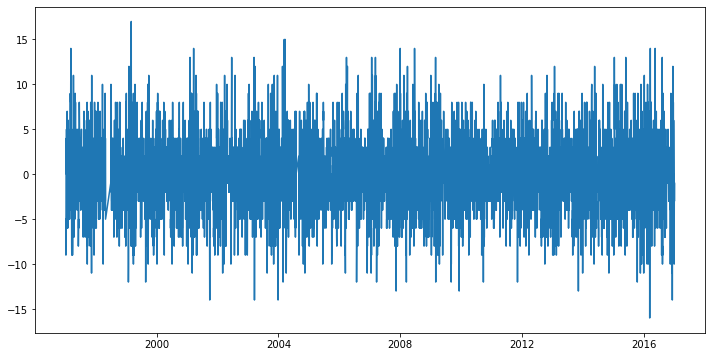

In [ ]:
#Ahora vamos a trabajar con la estacionalidad (variaciones debido a las estaciones del año)
#Existen dos métodos para eliminar la Estacionalidad:
#Diferenciación discreta (calcular diferencias involucrando un corrimiento 'shift()')
#Descomposición (Tendencia + Estacionalidad + Residuo)

#El metodo que utilizaremos sera el de Diferenciación discreta usando la función df.shift()
#Para la temperatura máxima
ts_test_max_diff=ts_max - ts_max.shift(periods=7)
plt.plot(ts_test_max_diff);

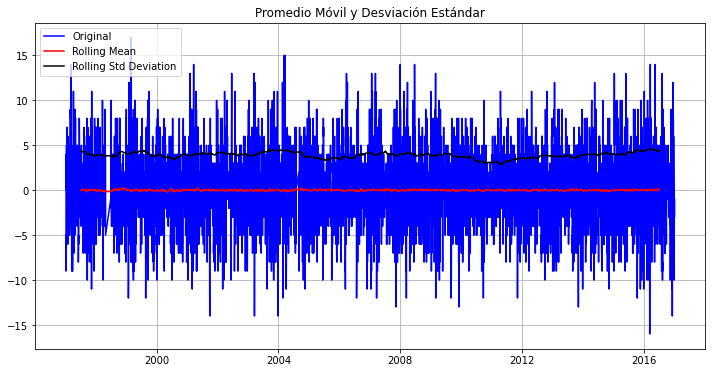

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -1.551236e+01
p-value                        2.339745e-28
#Lags Used                     3.500000e+01
Number of Observations Used    7.166000e+03
Critical Value (1%)           -3.431263e+00
Critical Value (5%)           -2.861943e+00
Critical Value (10%)          -2.566985e+00
dtype: float64
Numero de datos utilizados: 7202


In [ ]:
#Probamos la estacionaridad
ts_test_max_diff.dropna(inplace=True)
test_stationarity(ts_test_max_diff)
#Número de datos utilizados
print('Numero de datos utilizados:',len(ts_test_max_diff))

In [ ]:
#Podemos apreciar que el valor p de ADF: p < 0.05 (2.339745e-28) por lo tanto, sigue siendo una serie estacionaria

q=4 ; p=2


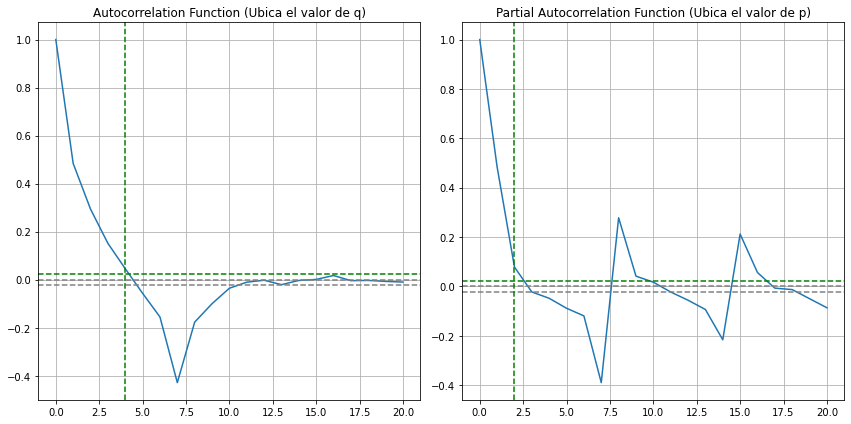

In [ ]:
#Ya que hemos confirmado que obtuvimos una serie de tiempo estacionaria, construiremos un modelo utilizando diferenciación, porque es fácil añadir el error, la tendencia y la estacionalidad a las predicciones.
#Utilizaremos el método ARIMA para el pronostico de la Serie de Tiempo para Temperatura Máxima
lag_acf = acf(ts_test_max_diff, nlags=20)
lag_pacf = pacf(ts_test_max_diff, nlags=20, method = 'ols')
#Tamaño de la gráficas
plt.rcParams["figure.figsize"] = (12,6)
#Gráfica de ACF (Autocorrelation Function)
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_test_max_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_test_max_diff)), linestyle='--', color='green')
#Graficamos unas líneas verticales como referencias que representan los intervalos de confianza
#plt.axvline(x=3, linestyle='--', color='green')
plt.axvline(x=4, linestyle='--', color='green')
plt.grid()
plt.title('Autocorrelation Function (Ubica el valor de q)')
#Gráfica de PACF (Partial Autocorrelation Function)
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_test_max_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_test_max_diff)), linestyle='--', color='green')
#Graficamos unas líneas verticales como referencias que representan los intervalos de confianza
plt.axvline(x=2, linestyle='--', color='green')
plt.grid()
plt.title('Partial Autocorrelation Function (Ubica el valor de p)')

plt.tight_layout()

print('q=4 ; p=2')


In [ ]:
#p es donde cruza el PACF el primer nivel de confianza superior, que en la gráfica derecha es cercana a 2, por lo que p=2.
#q es donde cruza la ACF el primer nivel de confianza superior, que en la gráfica izquierda es cercana a 4, por lo que haremos q=4.
#Con estos dos valores construiremos los modelos ARIMA correspondientes.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:              D.Tempmax   No. Observations:                 7208
Model:                 ARIMA(2, 1, 0)   Log Likelihood              -17205.993
Method:                       css-mle   S.D. of innovations              2.633
Date:                Wed, 24 Feb 2021   AIC                          34419.986
Time:                        06:52:28   BIC                          34447.518
Sample:                             1   HQIC                         34429.459
                                                                              
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0006      0.020      0.030      0.976      -0.038       0.039
ar.L1.D.Tempmax    -0.3790      0.012    -32.796      0.000      -0.402      -0.356
ar.L2.D.Tempmax    -0.1941      

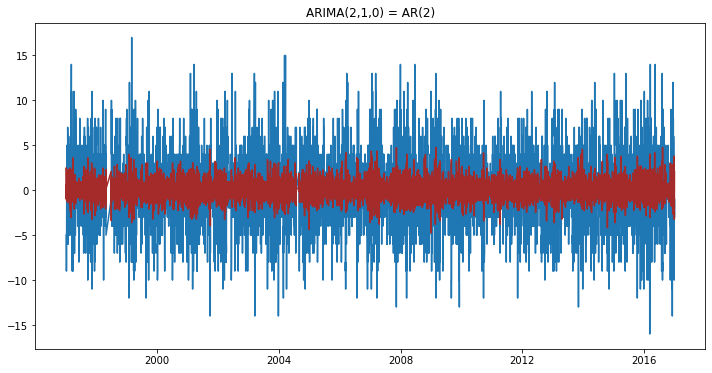

In [ ]:
#Modelo de ARIMA (Auto-Regresion)
#Modelo AR(p): (p,d,q) = (2,1,0) 
model=ARIMA(ts_max, order=(2,1,0), missing='drop')
results_AR=model.fit(displ=-1)
plt.plot(ts_test_max_diff)
plt.plot(results_AR.fittedvalues, color='brown')
plt.title('ARIMA(2,1,0) = AR(2)')
print(results_AR.summary())

In [ ]:
AR='AR: AIC =34419.989'

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:              D.Tempmax   No. Observations:                 7208
Model:                 ARIMA(0, 1, 4)   Log Likelihood              -16910.087
Method:                       css-mle   S.D. of innovations              2.527
Date:                Wed, 24 Feb 2021   AIC                          33832.175
Time:                        06:52:30   BIC                          33873.472
Sample:                             1   HQIC                         33846.384
                                                                              
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0006      0.007      0.088      0.930      -0.013       0.014
ma.L1.D.Tempmax    -0.4831      0.012    -41.103      0.000      -0.506      -0.460
ma.L2.D.Tempmax    -0.1408      

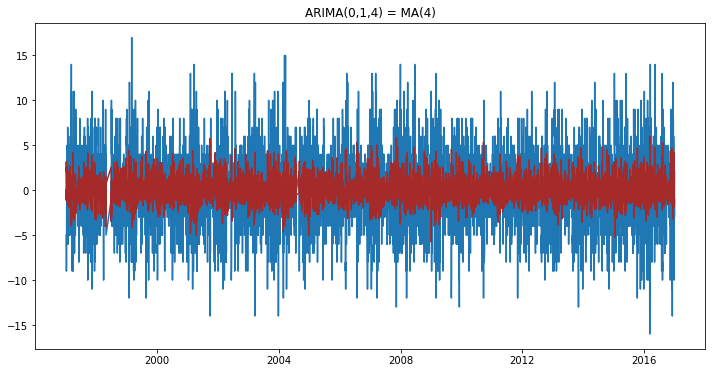

In [ ]:
#Ahora utilizaremos el Modelo del Promedio Movil
#Modelo MA(q): (p,d,q) = (0,1,4) 
model = ARIMA(ts_max, order=(0,1,4), missing='drop')
results_MA = model.fit(displ=-1)
plt.plot(ts_test_max_diff)
plt.plot(results_MA.fittedvalues, color='brown')
plt.title('ARIMA(0,1,4) = MA(4)')
print(results_MA.summary())

In [ ]:
MA='MA: AIC =33832.175'

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:              D.Tempmax   No. Observations:                 7208
Model:                 ARIMA(2, 1, 4)   Log Likelihood              -16901.151
Method:                       css-mle   S.D. of innovations              2.524
Date:                Wed, 24 Feb 2021   AIC                          33818.301
Time:                        06:52:37   BIC                          33873.365
Sample:                             1   HQIC                         33837.248
                                                                              
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0006      0.007      0.098      0.922      -0.012       0.013
ar.L1.D.Tempmax     1.0191      0.265      3.839      0.000       0.499       1.539
ar.L2.D.Tempmax    -0.3508      

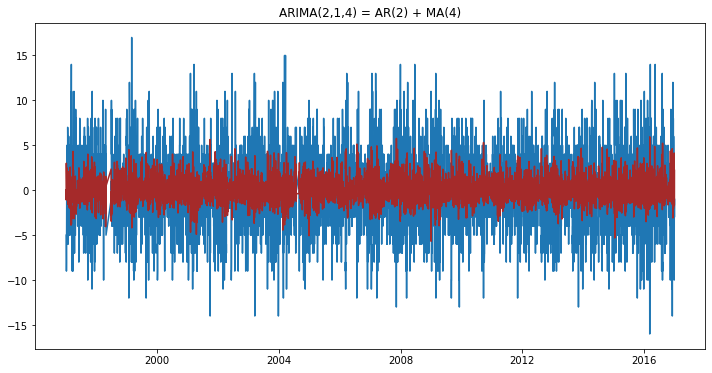

In [ ]:
#Modelo ARIMA de Auto-Regresion + Promedio Movil
#Modelo ARIMA(p): (p,d,q) = (2,1,4) 
model=ARIMA(ts_max, order=(2,1,4), missing='drop')
results_ARIMA=model.fit(displ=-1)
plt.plot(ts_test_max_diff)
plt.plot(results_ARIMA.fittedvalues, color='brown')
plt.title('ARIMA(2,1,4) = AR(2) + MA(4)')
print(results_ARIMA.summary())

In [ ]:
ARIMA='ARIMA: AIC =33818.301'

In [ ]:
#Para definir cual de los metodos ARIMA anteriores es el mejor indicador nos fijaremso en un criterio, este es El Criterio de Información de Akaike (AIC)
#El criterio AIC se basa en dos principios:
#Bondad del ajuste y Simplicidad del modelo o principio de parsimonia.
#Aquel modelo que tenga el menor AIC, y los valores más pequeños de (p,d,q) se selecciona como el mejor modelo de ajuste.
#Imprimimos los valores de AIC de los distintos modelos
print('AIC de los distintos modelos:')
print(AR,';',MA,';',ARIMA)

AIC de los distintos modelos:
AR: AIC =34419.989 ; MA: AIC =33832.175 ; ARIMA: AIC =33818.301


In [ ]:
#Podemos concluir que el mejor modelo es el de ARIMA (Auto-regresion + promedio movil) con un AIC de 33818.301
print('ARIMA(2,1,4)=33818.301 , ARIMA con el AIC más pequeño')

ARIMA(2,1,4)=33818.301 , ARIMA con el AIC más pequeño


In [ ]:
#Finalmente, definimos una serie de tiempo con las predicciones obtenidas por el método ARIMA
predictions_ARIMA_diff=pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff)

Fecha
1997-01-02    0.000639
1997-01-03   -0.952134
1997-01-04   -0.964461
1997-01-05   -1.058569
1997-01-06    0.023828
                ...   
2016-12-27    4.142380
2016-12-28    2.599627
2016-12-29   -1.679546
2016-12-30   -0.415022
2016-12-31    2.204382
Length: 7208, dtype: float64


In [ ]:
#Le sumamos las predicciones de ARIMA a la serie observada (ts_max)
predictions_ARIMA=pd.Series(ts_max, index=ts_max.index)
predictions_ARIMA=predictions_ARIMA.add(predictions_ARIMA_diff)
#Imprimimos el encabezado y pie de la Prediccion de ARIMA
print(predictions_ARIMA.head())
print(predictions_ARIMA.tail())

Fecha
1997-01-01          NaN
1997-01-02    27.000639
1997-01-03    27.047866
1997-01-04    28.035539
1997-01-05    25.941431
dtype: float64
Fecha
2016-12-27    27.142380
2016-12-28    33.599627
2016-12-29    28.320454
2016-12-30    24.584978
2016-12-31    33.204382
dtype: float64


El error de la Raiz Cuadrada de la Media es: 1.281360415628845


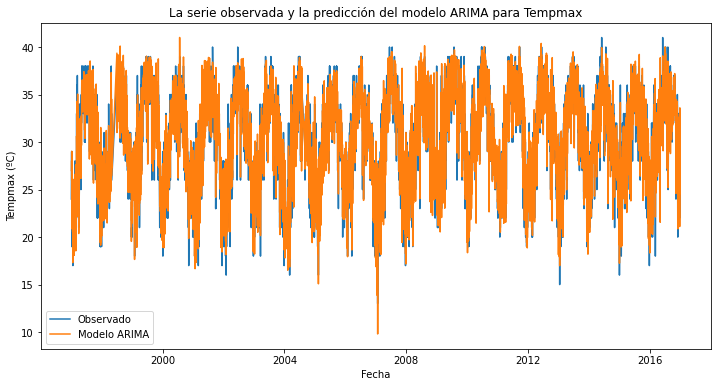

In [ ]:
#Realizamos la gráfica de la serie original en comparativa con las predicciones con ARIMA
#Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)
#Etiquetas de titulo y ejes
plt.plot(ts_max, label='Observado');
plt.plot(predictions_ARIMA, label='Modelo ARIMA');
plt.xlabel('Fecha')
plt.ylabel('Tempmax (ºC)')
plt.title('La serie observada y la predicción del modelo ARIMA para Tempmax')
plt.legend(loc='best');
#Calculamos el RMSE (Root Mean Square Error - Error de la Raiz Cuadrada de la Media)
RMSE = np.sqrt(np.mean((predictions_ARIMA - ts_max)**2))
print('El error de la Raiz Cuadrada de la Media es:', RMSE)

**Para la Temperatura Minima**

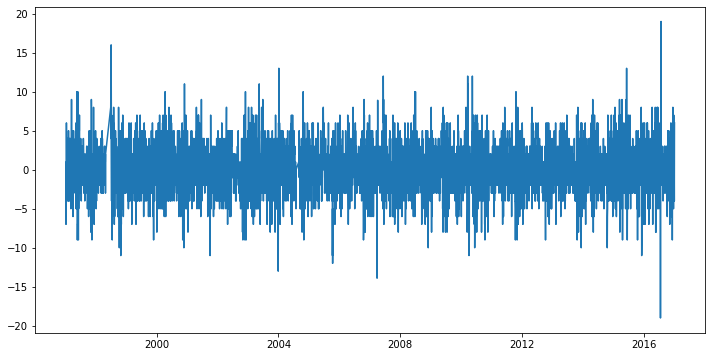

In [ ]:
#Ahora vamos a trabajar con la estacionalidad (variaciones debido a las estaciones del año)

#El metodo que utilizaremos sera el de Diferenciación discreta usando la función df.shift()
#Para la temperatura minima
ts_test_min_diff = ts_min - ts_min.shift(periods=7)
plt.plot(ts_test_min_diff);

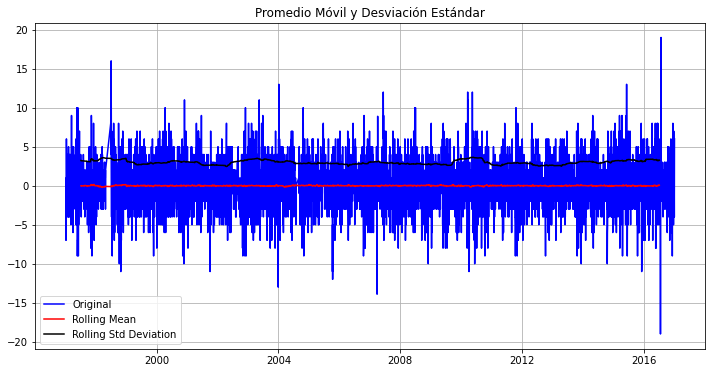

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -1.277221e+01
p-value                        7.727439e-24
#Lags Used                     3.500000e+01
Number of Observations Used    7.166000e+03
Critical Value (1%)           -3.431263e+00
Critical Value (5%)           -2.861943e+00
Critical Value (10%)          -2.566985e+00
dtype: float64
Numero de datos utilizados: 7202


In [ ]:
#Probamos la estacionaridad
ts_test_min_diff.dropna(inplace=True)
test_stationarity(ts_test_min_diff)
#Número de datos utilizados
print('Numero de datos utilizados:',len(ts_test_min_diff))

In [ ]:
#Podemos apreciar que el valor p de ADF: p < 0.05 (7.727439e-24) por lo tanto, sigue siendo una serie estacionaria

q=4 ; p=2


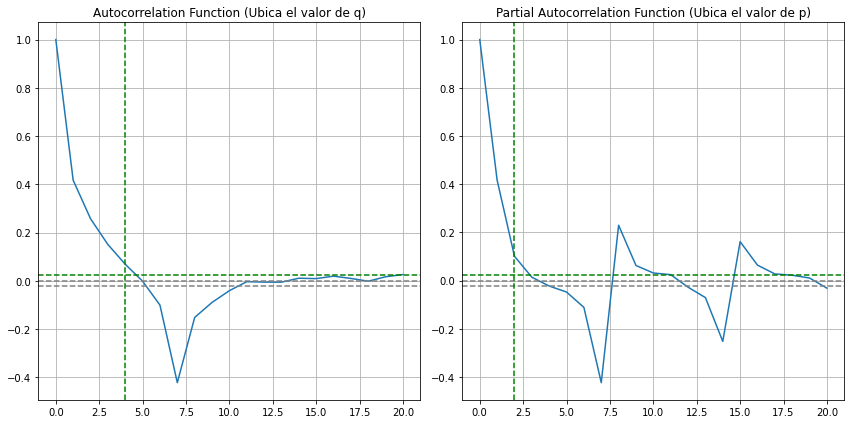

In [ ]:
#Ya que hemos confirmado que obtuvimos una serie de tiempo estacionaria, construiremos un modelo utilizando diferenciación, porque es fácil añadir el error, la tendencia y la estacionalidad a las predicciones.
#Utilizaremos el método ARIMA para el pronostico de la Serie de Tiempo para Temperatura Minima
lag_acf = acf(ts_test_min_diff, nlags=20)
lag_pacf = pacf(ts_test_min_diff, nlags=20, method = 'ols')
#Tamaño de la gráficas
plt.rcParams["figure.figsize"] = (12,6)
#Gráfica de ACF (Autocorrelation Function)
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_test_min_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_test_min_diff)), linestyle='--', color='green')
#Graficamos unas líneas verticales como referencias que representan los intervalos de confianza
#plt.axvline(x=3, linestyle='--', color='green')
plt.axvline(x=4, linestyle='--', color='green')
plt.grid()
plt.title('Autocorrelation Function (Ubica el valor de q)')
#Gráfica de PACF (Partial Autocorrelation Function)
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_test_min_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_test_min_diff)), linestyle='--', color='green')
#Graficamos unas líneas verticales como referencias que representan los intervalos de confianza
plt.axvline(x=2, linestyle='--', color='green')
plt.grid()
plt.title('Partial Autocorrelation Function (Ubica el valor de p)')

plt.tight_layout()

print('q=4 ; p=2')

In [ ]:
#p es donde cruza el PACF el primer nivel de confianza superior, que en la gráfica derecha es cercana a 2, por lo que p=2.
#q es donde cruza la ACF el primer nivel de confianza superior, que en la gráfica izquierda es cercana a 4, por lo que haremos q=4.
#Con estos dos valores construiremos los modelos ARIMA correspondientes.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:              D.Tempmin   No. Observations:                 7208
Model:                 ARIMA(2, 1, 0)   Log Likelihood              -15524.816
Method:                       css-mle   S.D. of innovations              2.085
Date:                Wed, 24 Feb 2021   AIC                          31057.632
Time:                        07:03:14   BIC                          31085.163
Sample:                             1   HQIC                         31067.105
                                                                              
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0009      0.015      0.057      0.954      -0.028       0.030
ar.L1.D.Tempmin    -0.4451      0.012    -38.670      0.000      -0.468      -0.423
ar.L2.D.Tempmin    -0.2117      

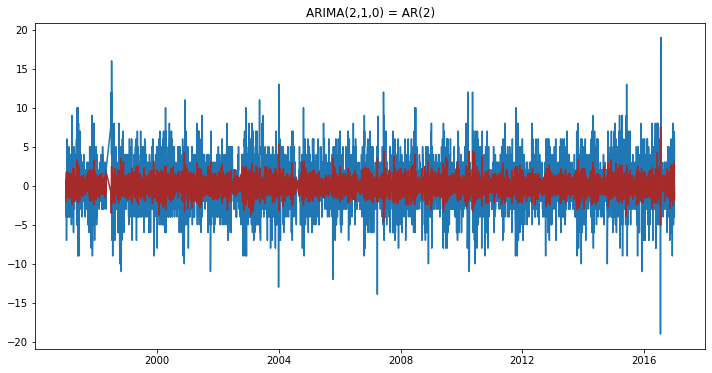

In [ ]:
#Modelo de ARIMA (Auto-Regresion)
#Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)
#Modelo AR(p): (p,d,q) = (2,1,0)  
model = ARIMA(ts_min, order=(2,1,0), missing='drop')
results_AR2=model.fit(displ=-1)
plt.plot(ts_test_min_diff)
plt.plot(results_AR2.fittedvalues, color='brown')
plt.title('ARIMA(2,1,0) = AR(2)')
print(results_AR2.summary())

In [ ]:
#Ahora utilizaremos el Modelo del Promedio Movil
#Modelo MA(q): (p,d,q) = (0,1,4) 
model = ARIMA(ts_min, order=(0,1,4), missing='drop')
results_MA2= model.fit(displ=-1)
plt.plot(ts_test_min_diff)
plt.plot(results_MA2.fittedvalues, color='brown')
plt.title('ARIMA(0,1,4) = MA(4)')
print(results_MA2.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ValueError: ignored

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:              D.Tempmin   No. Observations:                 7208
Model:                 ARIMA(2, 1, 4)   Log Likelihood              -15230.146
Method:                       css-mle   S.D. of innovations              2.002
Date:                Wed, 24 Feb 2021   AIC                          30476.292
Time:                        07:15:20   BIC                          30531.356
Sample:                             1   HQIC                         30495.239
                                                                              
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0006      0.006      0.101      0.920      -0.011       0.012
ar.L1.D.Tempmin    -0.3115      0.745     -0.418      0.676      -1.771       1.148
ar.L2.D.Tempmin     0.2705      

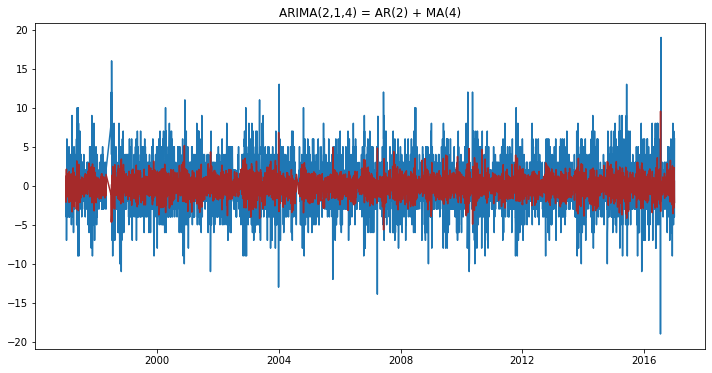

In [ ]:
#Modelo ARIMA de Auto-Regresion + Promedio Movil
#Modelo ARIMA(p): (p,d,q) = (2,1,4) 
model=ARIMA(ts_min, order=(2,1,4), missing='drop')
results_ARIMA2=model.fit(displ=-1)
plt.plot(ts_test_min_diff)
plt.plot(results_ARIMA2.fittedvalues, color='brown')
plt.title('ARIMA(2,1,4) = AR(2) + MA(4)')
print(results_ARIMA2.summary())

In [ ]:
#Podemos concluir que el mejor modelo es el de ARIMA (Auto-regresion) con un AIC de 30476.291
print('ARIMA(2,1,0)=30476.291 , ARIMA con el AIC más pequeño')

ARIMA(2,1,0)=30476.291 , ARIMA con el AIC más pequeño


In [ ]:
#Finalmente, definimos una serie de tiempo con las predicciones obtenidas por el método ARIMA
predictions2_ARIMA_diff=pd.Series(results_ARIMA2.fittedvalues, copy=True)
print(predictions2_ARIMA_diff)

Fecha
1997-01-02    0.000581
1997-01-03    0.000794
1997-01-04    0.445999
1997-01-05   -2.111183
1997-01-06    0.621427
                ...   
2016-12-27    2.309541
2016-12-28   -1.550376
2016-12-29    0.671698
2016-12-30   -0.672783
2016-12-31   -2.135878
Length: 7208, dtype: float64


In [ ]:
#Le sumamos las predicciones de ARIMA a la serie observada (ts_min)
predictions2_ARIMA=pd.Series(ts_min, index=ts_min.index)
predictions2_ARIMA=predictions2_ARIMA.add(predictions_ARIMA_diff)
#Imprimimos el encabezado y pie de la Prediccion de ARIMA
print(predictions2_ARIMA.head())
print(predictions2_ARIMA.tail())

Fecha
1997-01-01          NaN
1997-01-02     9.000639
1997-01-03     7.047866
1997-01-04    12.035539
1997-01-05     7.941431
dtype: float64
Fecha
2016-12-27    18.142380
2016-12-28    13.599627
2016-12-29    11.320454
2016-12-30    15.584978
2016-12-31    17.204382
dtype: float64


El error de la Raiz Cuadrada de la Media es: 1.281360415628845


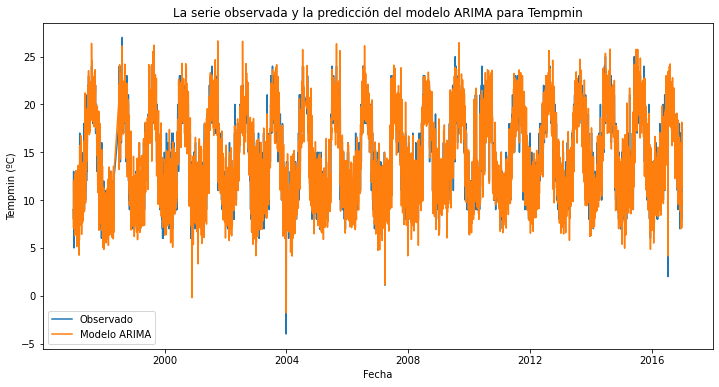

In [ ]:
#Realizamos la gráfica de la serie original en comparativa con las predicciones con ARIMA
#Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)
#Etiquetas de titulo y ejes
plt.plot(ts_min, label='Observado');
plt.plot(predictions2_ARIMA, label='Modelo ARIMA');
plt.xlabel('Fecha')
plt.ylabel('Tempmin (ºC)')
plt.title('La serie observada y la predicción del modelo ARIMA para Tempmin')
plt.legend(loc='best');
#Calculamos el RMSE (Root Mean Square Error - Error de la Raiz Cuadrada de la Media)
RMSE = np.sqrt(np.mean((predictions2_ARIMA - ts_min)**2))
print('El error de la Raiz Cuadrada de la Media es:', RMSE)